## Settings

In [1]:
setwd("~/git/hist_future_hail/") # Working directory.
source("modules/gev_functions.R") # Load helper functions.
variables <- c("hailcast_diam_max", "wind_10m") # Variables to process.
results_dir <- "/g/data/up6/tr2908/hist_future_hail/results/" # Results directory.
set.seed(42) # Random seed for reproducibility.

Set the time zone to UTC, otherwise times read in are all set to local time.

In [4]:
Sys.setenv(TZ = "GMT")

## Read in data

In [5]:
maxes <- read_feathers(results_dir = results_dir, pattern = "*_maxima.feather")
means <- read_feathers(results_dir = results_dir, pattern = "*_means.feather")


[1] "/g/data/up6/tr2908/hist_future_hail/results//Adelaide_hist_block_maxima.feather"
[1] "/g/data/up6/tr2908/hist_future_hail/results//Adelaide_ssp245_block_maxima.feather"
[1] "/g/data/up6/tr2908/hist_future_hail/results//Brisbane_hist_block_maxima.feather"
[1] "/g/data/up6/tr2908/hist_future_hail/results//Brisbane_ssp245_block_maxima.feather"
[1] "/g/data/up6/tr2908/hist_future_hail/results//Kalgoorlie_hist_block_maxima.feather"
[1] "/g/data/up6/tr2908/hist_future_hail/results//Kalgoorlie_ssp245_block_maxima.feather"
[1] "/g/data/up6/tr2908/hist_future_hail/results//Melbourne_hist_block_maxima.feather"
[1] "/g/data/up6/tr2908/hist_future_hail/results//Melbourne_ssp245_block_maxima.feather"
[1] "/g/data/up6/tr2908/hist_future_hail/results//Perth_hist_block_maxima.feather"
[1] "/g/data/up6/tr2908/hist_future_hail/results//Perth_ssp245_block_maxima.feather"
[1] "/g/data/up6/tr2908/hist_future_hail/results//Sydney_Canberra_hist_block_maxima.feather"
[1] "/g/data/up6/tr2908/hist_future_h

Convert wind speeds from m/s to km/h for analysis.

In [6]:
maxes['wind_10m'] = maxes['wind_10m'] * 3.6
means['wind_10m'] = means['wind_10m'] * 3.6

## Timeseries of maxima

First the timeseries of daily hail diameter maxima.

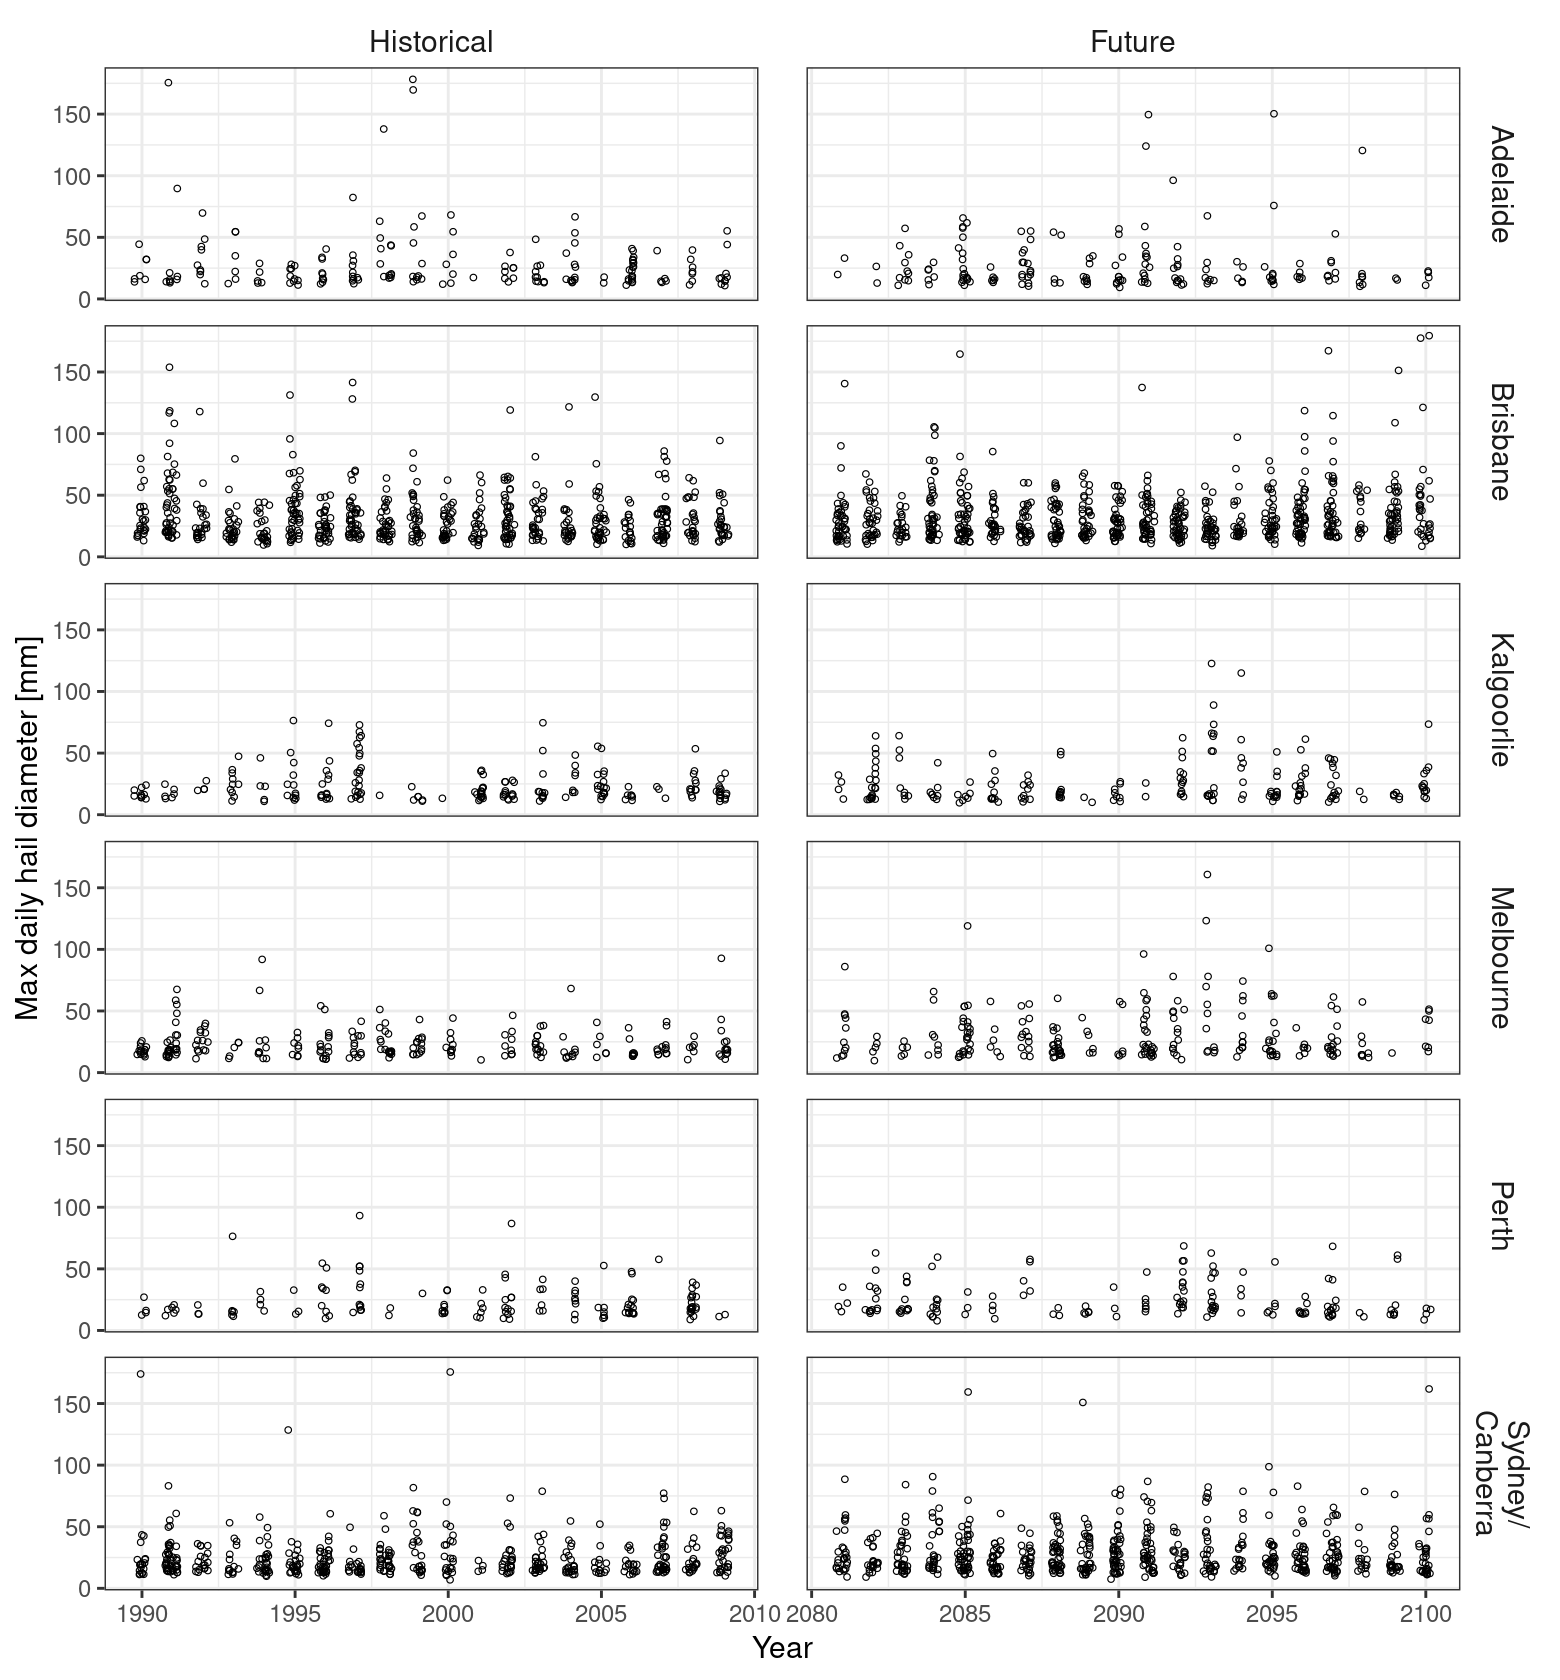

In [7]:
options(repr.plot.width = 13, repr.plot.height = 14)
plot_ts(
    dat = maxes, ylabel = "Max daily hail diameter [mm]", var = "hailcast_diam_max",
    file = "paper/supporting info/figures/timeseries_hail.pdf"
)


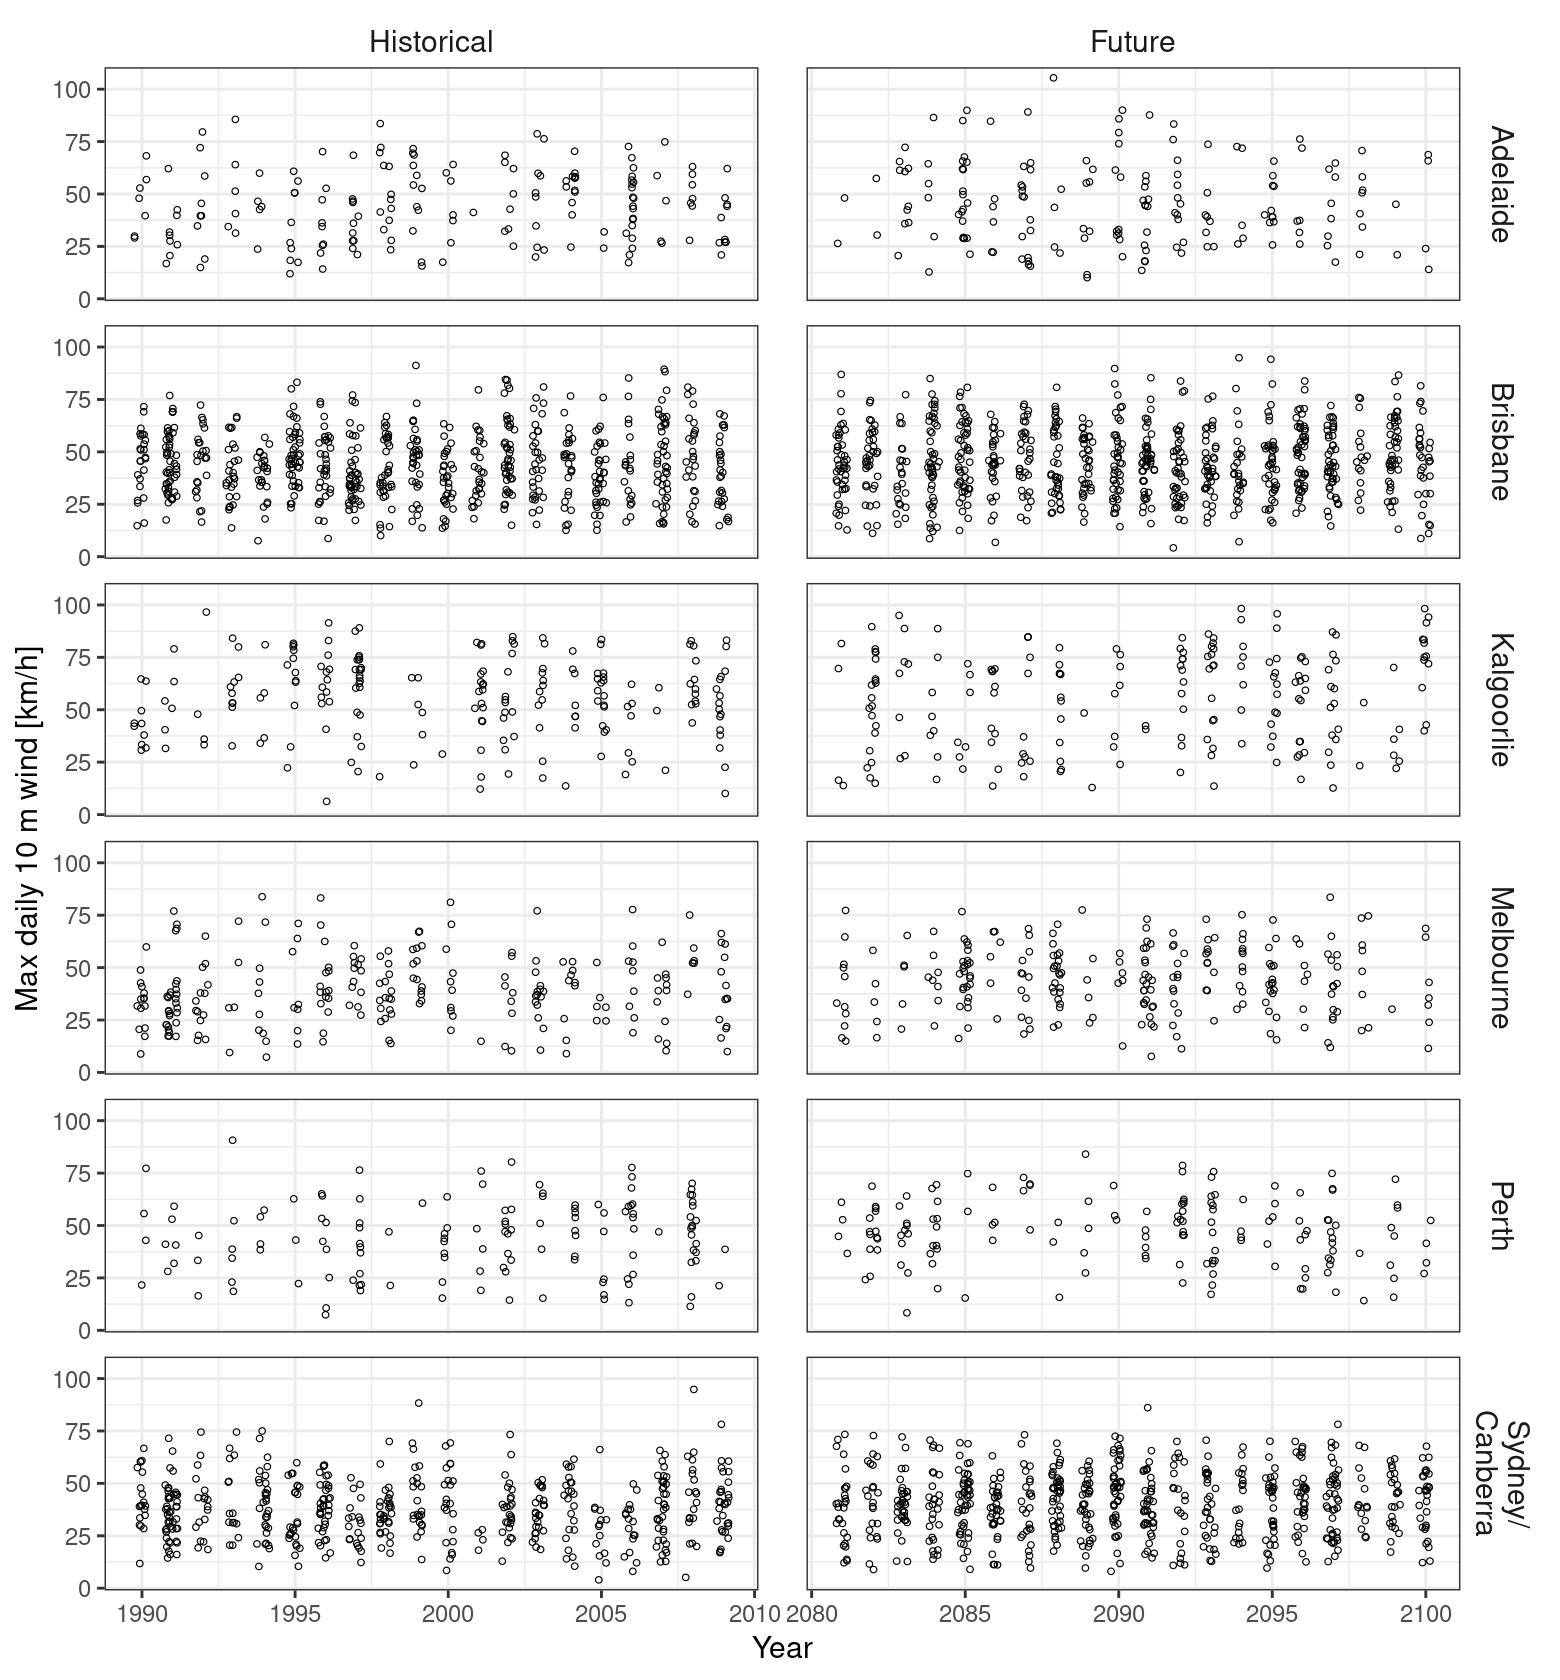

In [8]:
plot_ts(
    dat = maxes, ylabel = "Max daily 10 m wind [km/h]", var = "wind_10m",
    file = "paper/supporting info/figures/timeseries_wind.pdf"
)


## Hail frequency changes


# A tibble: 6 × 11
  domain       estimate estimate1 estimate2 statistic p.value parameter conf.low
  <chr>           <dbl>     <dbl>     <dbl>     <dbl>   <dbl>     <dbl>    <dbl>
1 Adelaide       -0.350      8.35       8.7   -0.242   0.810       37.1   -3.28 
2 Brisbane        4.85      37.8       33.0    1.79    0.0813      37.9   -0.632
3 Kalgoorlie     -0.200      9.8       10     -0.112   0.911       37.3   -3.81 
4 Melbourne      -0.200     11.5       11.7   -0.0971  0.923       36.8   -4.37 
5 Perth           0.75       7.55       6.8    0.486   0.630       38.0   -2.38 
6 Sydney/Canb…    7.1       31.4       24.3    2.44    0.0194      37.9    1.21 
# ℹ 3 more variables: conf.high <dbl>, method <chr>, alternative <chr>


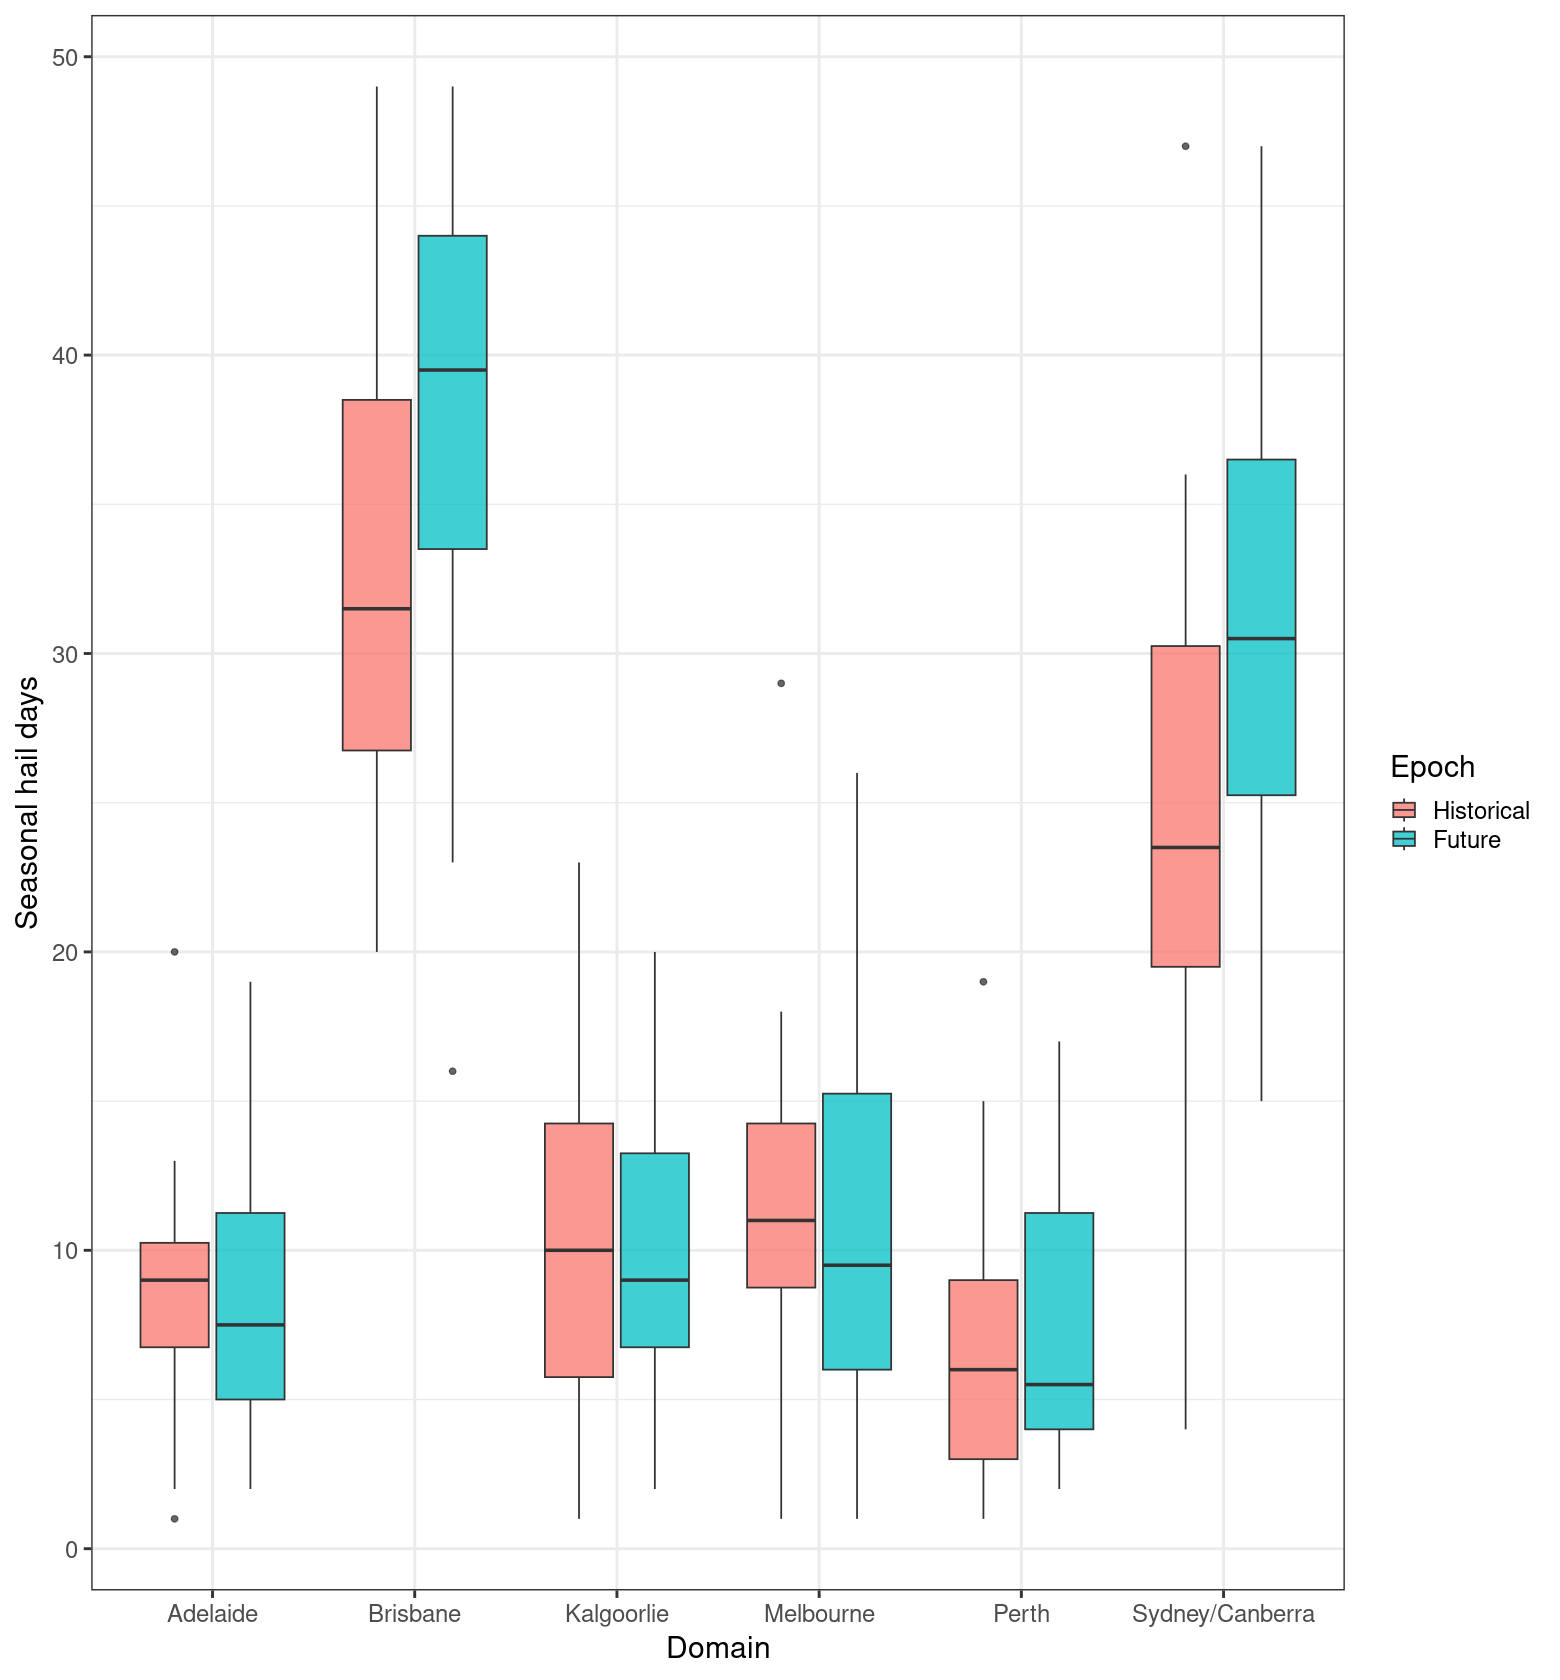

In [9]:
day_changes = hail_day_changes(dat = maxes, out_file = "paper/supporting info/tables/hail_freq_table.tex")

## GEV fitting

In [10]:
require(lubridate)

hist_dates = seq(ymd("1989-10-01"), ymd("2009-02-28"), by = "days")
fut_dates = seq(ymd("2080-10-01"), ymd("2100-02-28"), by = "days")

hist_dates = hist_dates[month(hist_dates) %in% c(10, 11, 12, 1, 2)]
fut_dates = fut_dates[month(fut_dates) %in% c(10, 11, 12, 1, 2)]

hist_dates = hist_dates[!(month(hist_dates) == 2 & day(hist_dates) == 29)]
fut_dates = fut_dates[!(month(fut_dates) == 2 & day(fut_dates) == 29)]

all_times = rbind(
    tibble(time = hist_dates, epoch = "historical"),
    tibble(time = fut_dates, epoch = "ssp245")
)

times = tibble()

for (d in unique(maxes$domain)) {
    times = rbind(times, cbind(all_times, list(domain = d)))
}

padded_maxes = full_join(maxes, times, by = c("epoch", "domain", "time")) %>%
    arrange(time) %>%
    select(epoch, domain, time, hailcast_diam_max, wind_10m) %>%
    mutate(
        hailcast_diam_max = replace_na(hailcast_diam_max, 0),
        wind_10m = replace_na(wind_10m, 0)
    )

domain,hailsize,wind
<chr>,<dbl>,<dbl>
Adelaide,19.16519,43.96825
Brisbane,25.85711,43.81369
Kalgoorlie,18.66027,57.78214
Melbourne,20.35350,40.89201
Perth,18.56094,46.95509
Sydney/Canberra,21.33321,39.09477


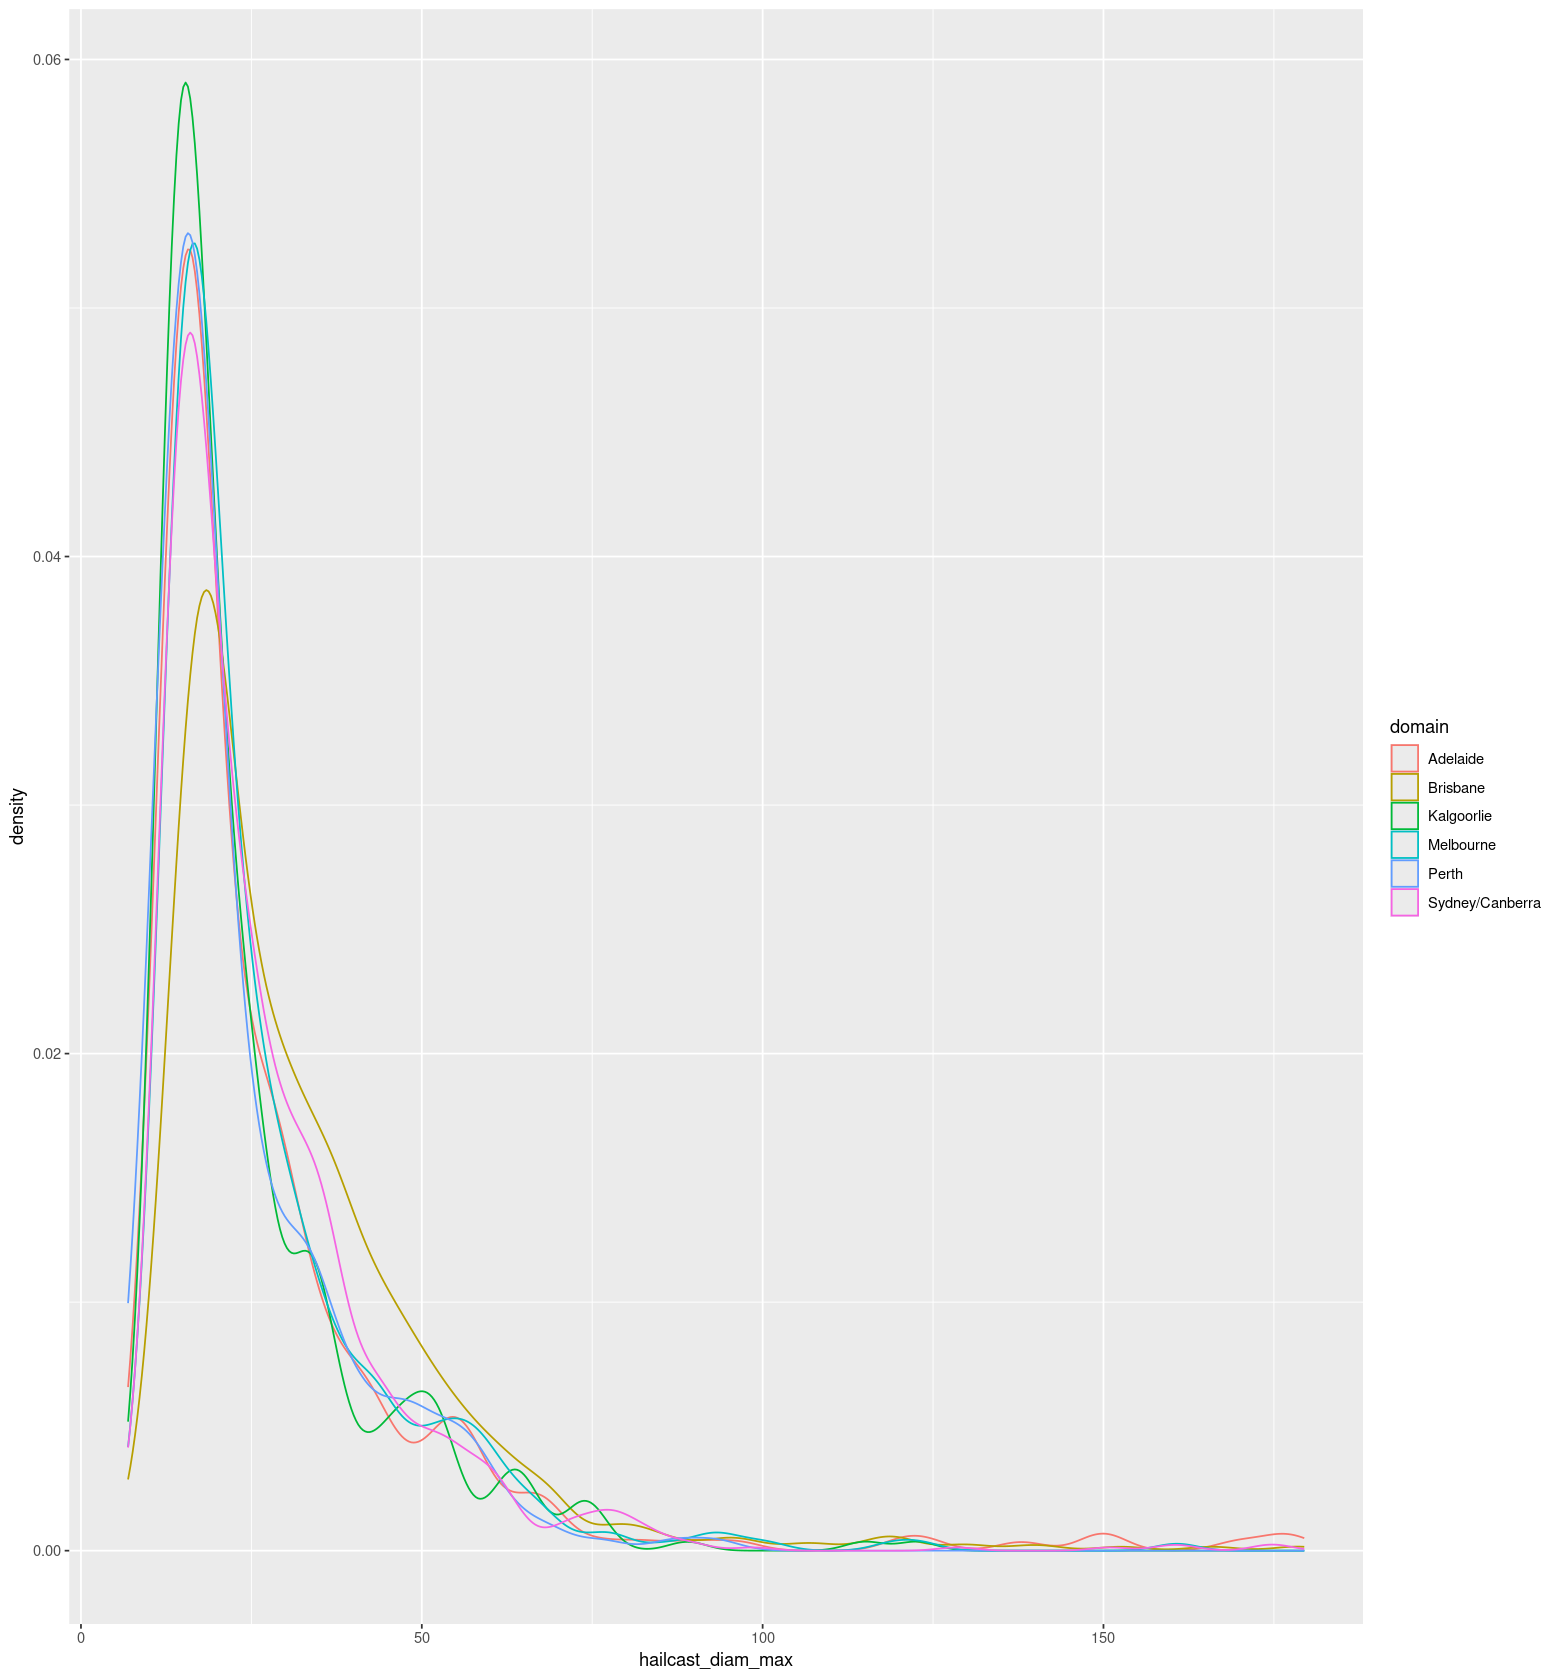

In [11]:
maxes %>%
    group_by(domain) %>%
    summarise(
        hailsize = median(hailcast_diam_max),
        wind = median(wind_10m)
    )

maxes %>% ggplot(aes(x = hailcast_diam_max)) +
    geom_density(aes(group=domain, color=domain))

In [12]:
stopifnot(!any(maxes$wind_10m == 0))

In [13]:
source("modules/gev_functions.R")

gp_thresholds = list("hailcast_diam_max" = 20, "wind_10m" = NA)
ev_types = list("hailcast_diam_max" = "GP", "wind_10m" = "GEV")

gev_fits <- fit_gevs(
    all_dat = padded_maxes,
    gp_thresholds = gp_thresholds,
    ev_types = ev_types
)

[1] "Fitting for hailcast_diam_max in Kalgoorlie for historical"
[1] "Fitting for hailcast_diam_max in Kalgoorlie for ssp245"
[1] "Fitting for wind_10m in Kalgoorlie for historical"
[1] "Fitting for wind_10m in Kalgoorlie for ssp245"
[1] "Fitting for hailcast_diam_max in Adelaide for historical"
[1] "Fitting for hailcast_diam_max in Adelaide for ssp245"
[1] "Fitting for wind_10m in Adelaide for historical"
[1] "Fitting for wind_10m in Adelaide for ssp245"
[1] "Fitting for hailcast_diam_max in Brisbane for historical"
[1] "Fitting for hailcast_diam_max in Brisbane for ssp245"
[1] "Fitting for wind_10m in Brisbane for historical"
[1] "Fitting for wind_10m in Brisbane for ssp245"
[1] "Fitting for hailcast_diam_max in Melbourne for historical"
[1] "Fitting for hailcast_diam_max in Melbourne for ssp245"
[1] "Fitting for wind_10m in Melbourne for historical"
[1] "Fitting for wind_10m in Melbourne for ssp245"
[1] "Fitting for hailcast_diam_max in Perth for historical"
[1] "Fitting for hailcas

Warning message in ks.test.default(rextRemes(gevs[[d]][[v]][["historical"]], 1000), :
“p-value will be approximate in the presence of ties”
Warning message in ks.test.default(rextRemes(gevs[[d]][[v]][["historical"]], 1000), :
“p-value will be approximate in the presence of ties”
Warning message in ks.test.default(rextRemes(gevs[[d]][[v]][["historical"]], 1000), :
“p-value will be approximate in the presence of ties”


Plot GEV curves for each domain and epoch.

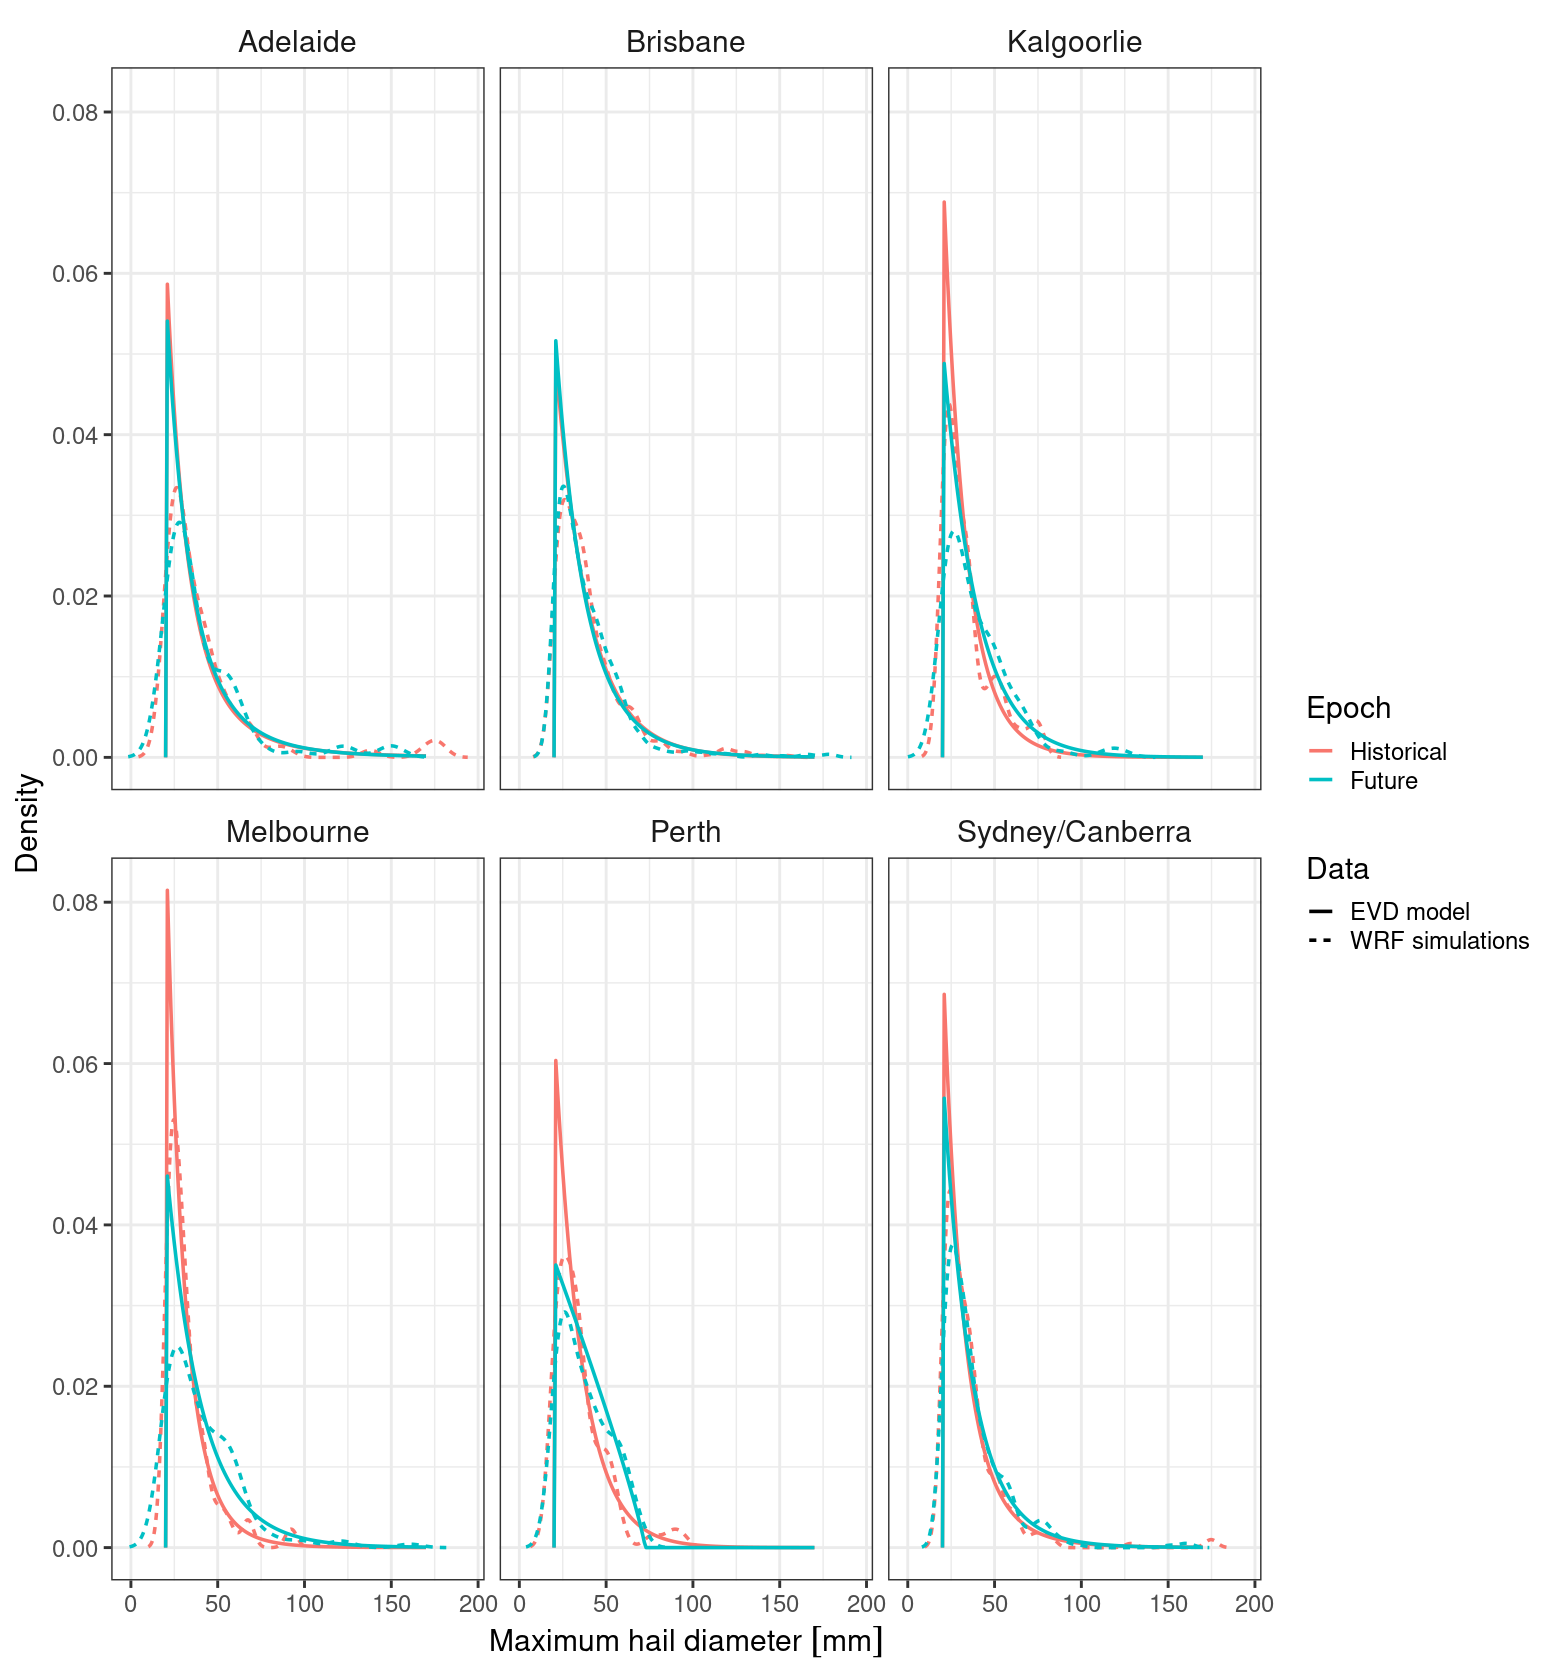

In [14]:
source("modules/gev_functions.R")
plot_densities(
    gev_fits = gev_fits, 
    variable = "hailcast_diam_max",
    ev_types = ev_types,
    gp_thresholds = gp_thresholds,
    label = "Maximum~hail~diameter~group('[',mm,']')",
    file = "paper/supporting info/figures/gev_dists_hail.pdf"
)


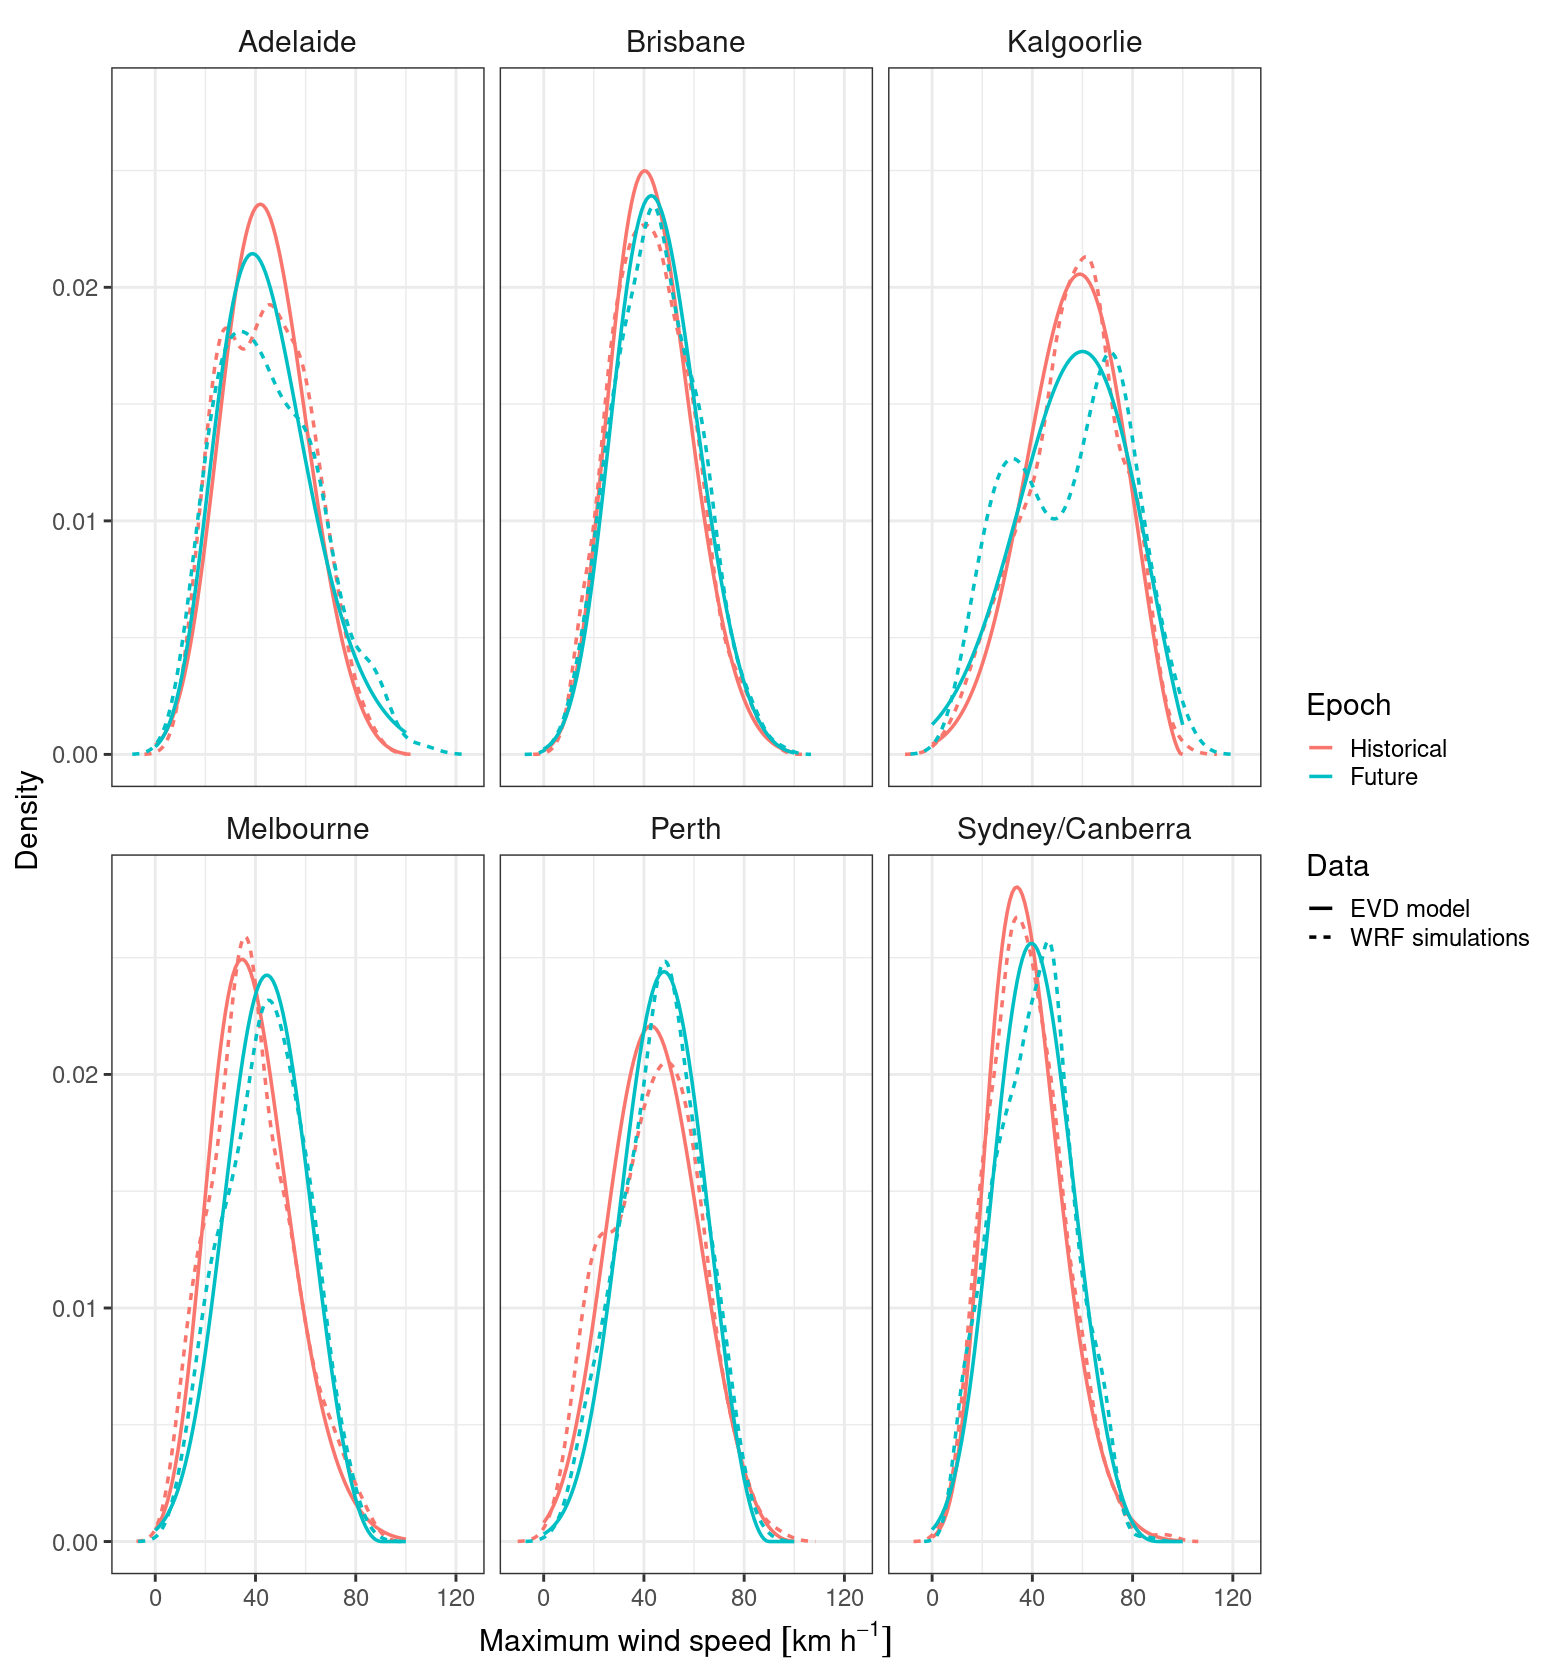

In [15]:
plot_densities(
    gev_fits = gev_fits,
    variable = "wind_10m",
    ev_types = ev_types,
    x = seq(0, 100),
    label = "Maximum~wind~speed~group('[',km~h^{-1},']')",
    file = "paper/supporting info/figures/gev_dists_wind.pdf"
)

Plot parameters and their confidence intervals of each model in historic and ssp245 epochs; we consider two models significantly different if at least one parameter has non-overlapping confidence intervals.

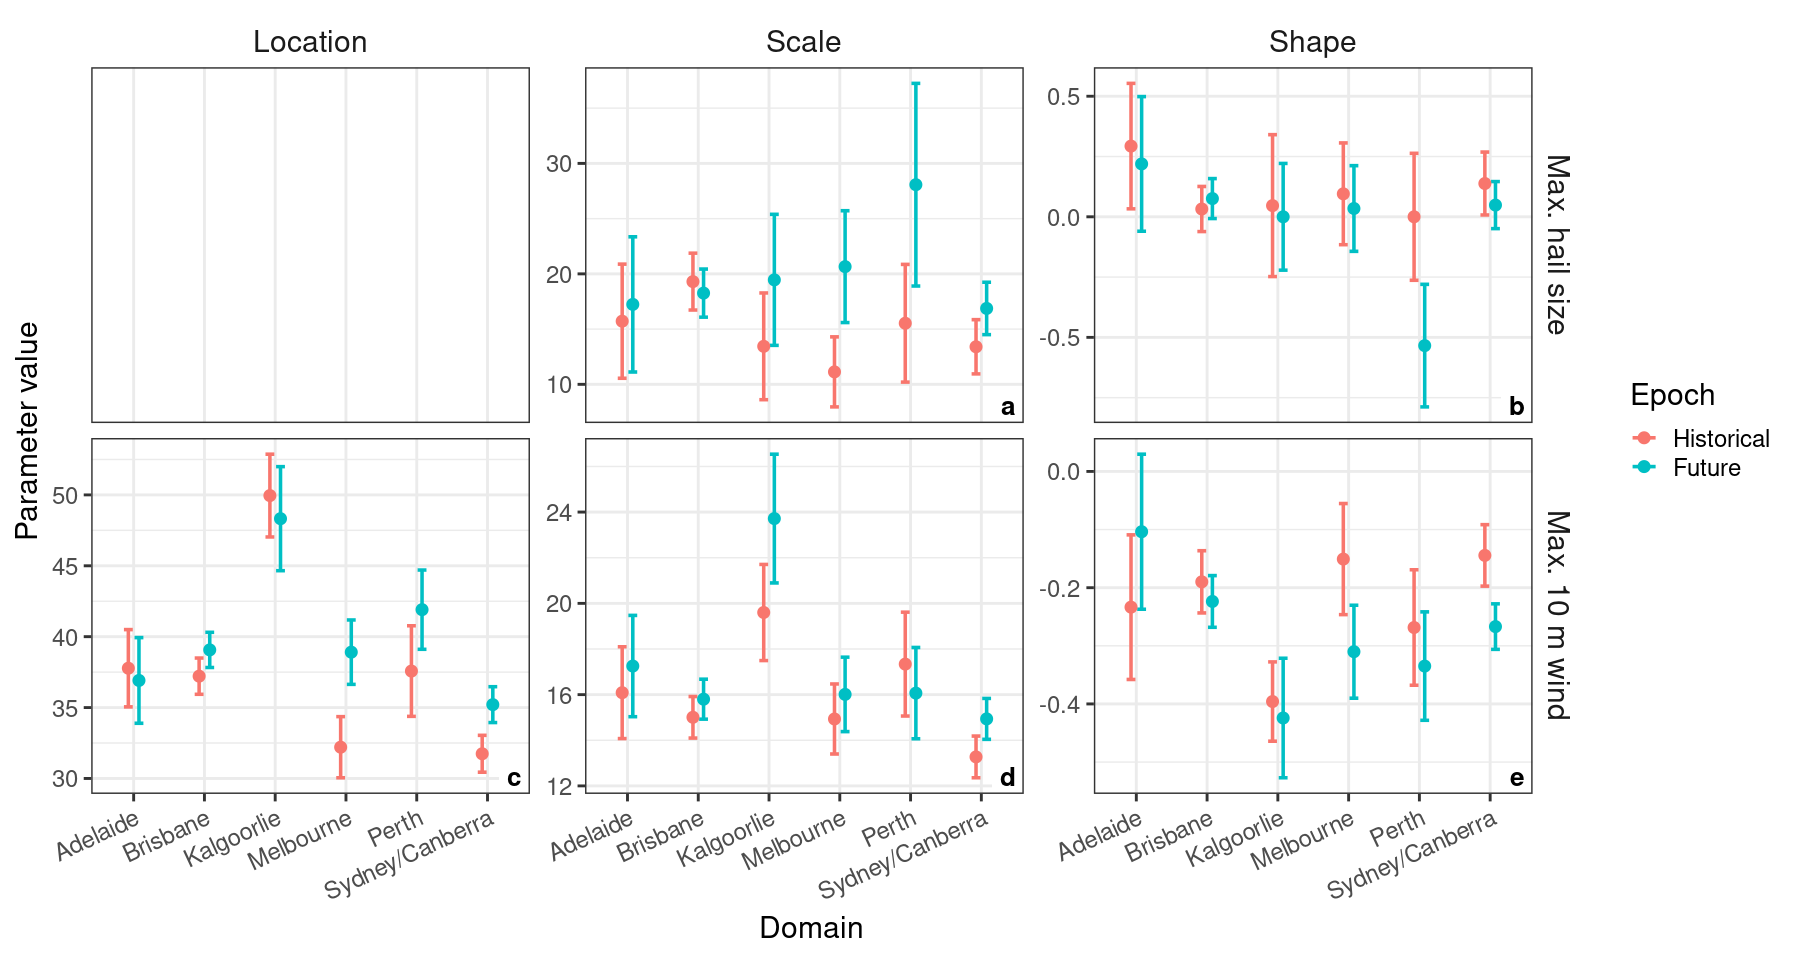

In [16]:
options(repr.plot.width = 15, repr.plot.height = 8)
plot_params(gev_fits = gev_fits, file = "paper/supporting info/figures/fit_params.pdf")


We use the KS test to see whether a) the GEV model and training data are from different distributions, and b) whether the historic vs ssp245 models are considered significantly different. For each comparison we draw 1000 points from the modelled distribution(s) and do the KS test 100 times to get a distribution of p values. If most p values are below 0.05 then the null hypothesis that the two samples come from the same distribution can be rejected.

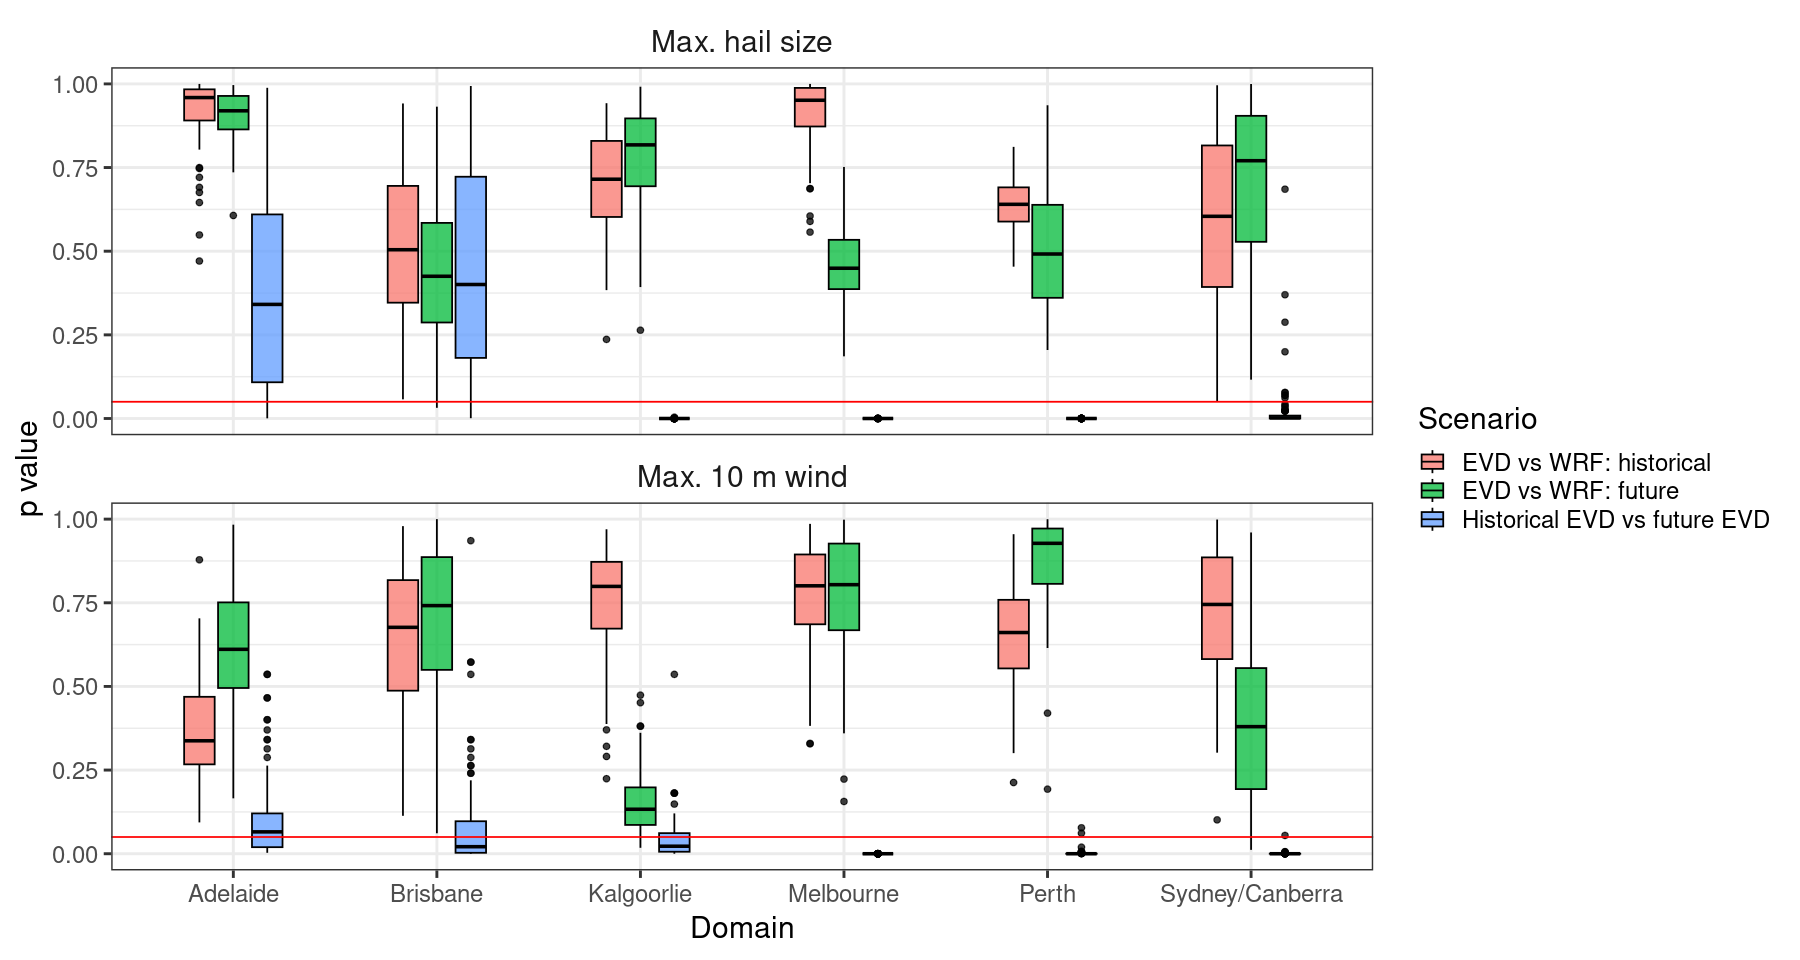

In [17]:
options(repr.plot.width = 15, repr.plot.height = 8)
plot_ks_fits(gev_fits = gev_fits, file = "paper/supporting info/figures/fit_pvals.pdf")


## Goodness of fit

QQ plots show goodness of fit between WRF-simulated and GEV-modelled values.

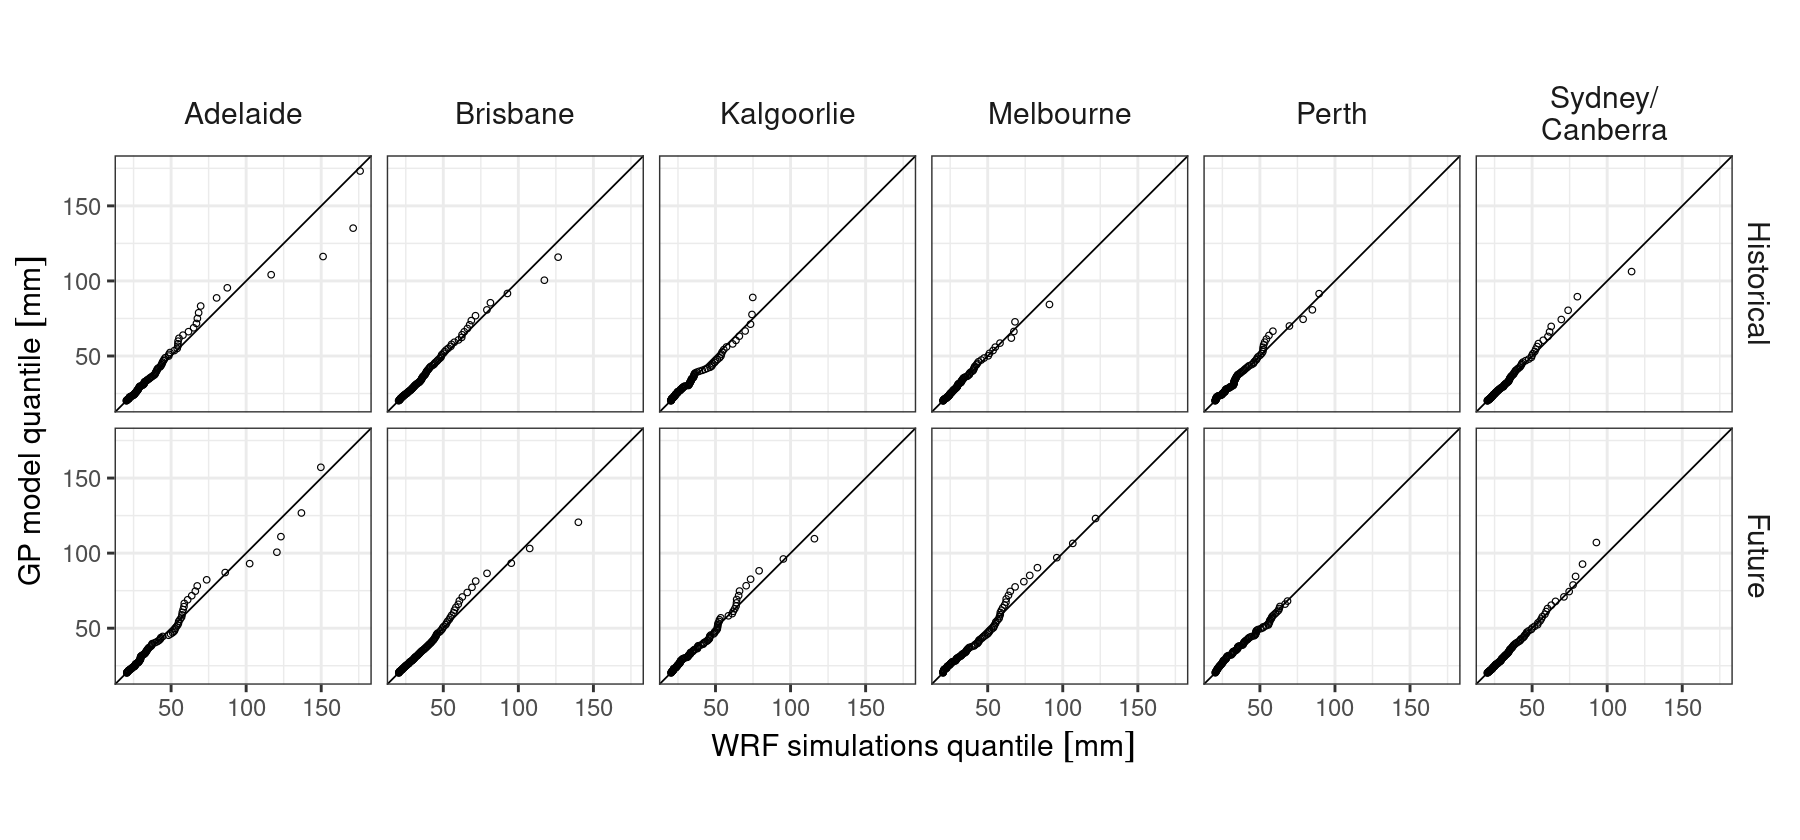

In [18]:
options(repr.plot.width = 15, repr.plot.height = 7)
plot_quantiles(
    gev_fits = gev_fits, var = "hailcast_diam_max", unit = "mm",
    file = "paper/supporting info/figures/qq_hail.pdf"
)


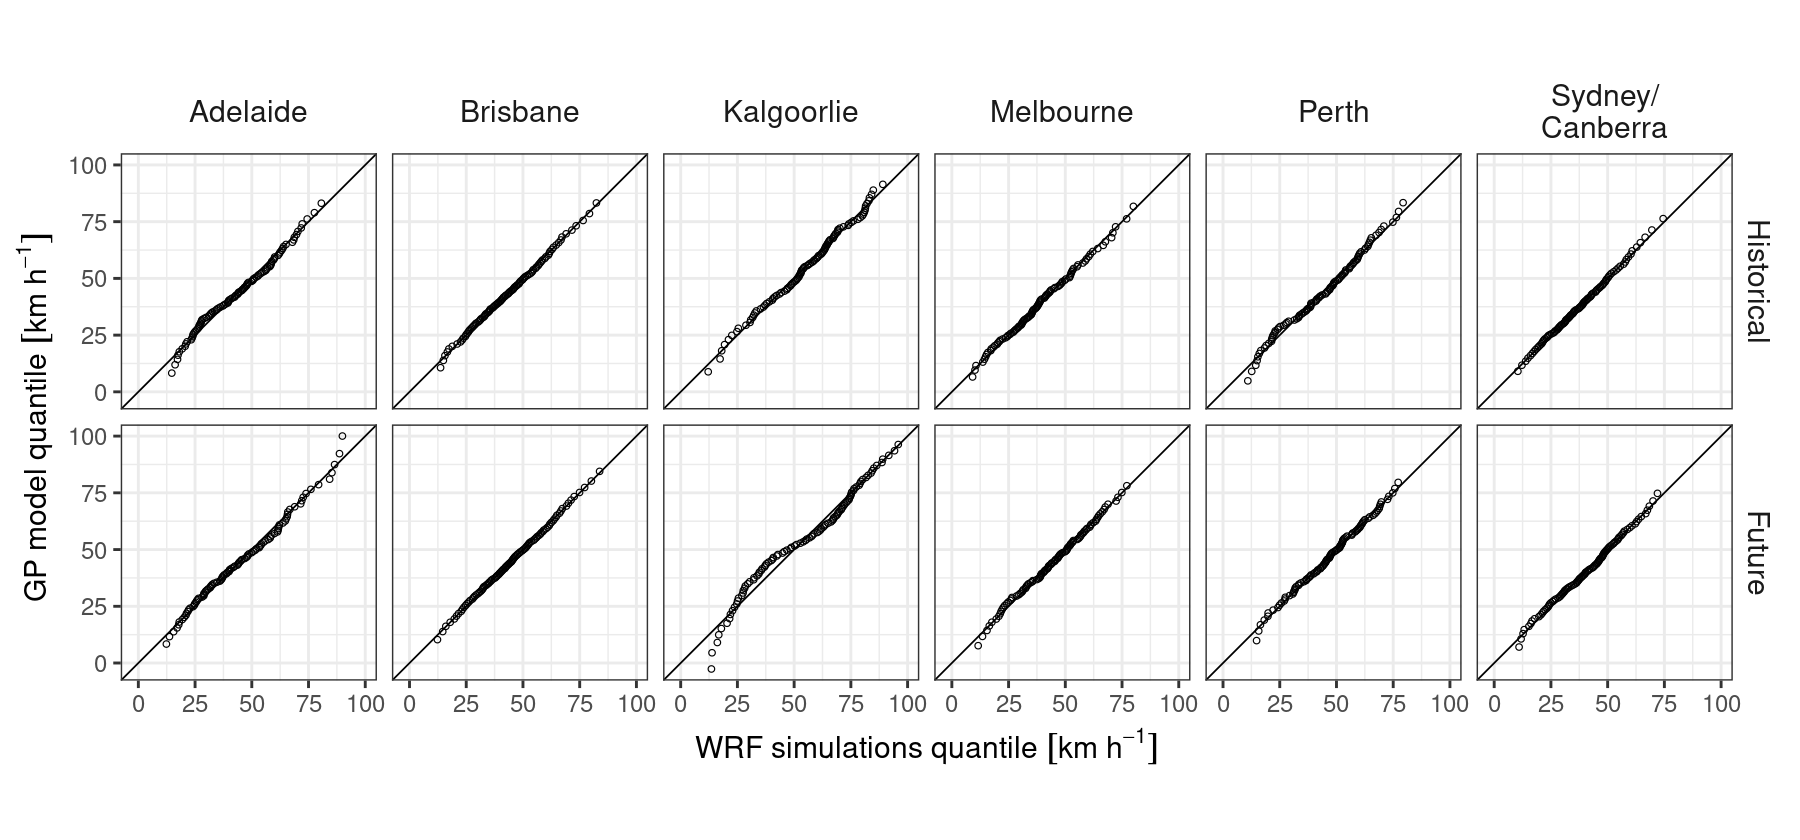

In [19]:
plot_quantiles(
    gev_fits = gev_fits, var = "wind_10m", unit = "km~h^{-1}",
    file = "paper/supporting info/figures/qq_wind.pdf"
)


## Return periods

Return periods in number of hail days (extRemes always says number of years but assumes each maxima is an annual maxima). Note return levels may be nonphysical for long return periods.

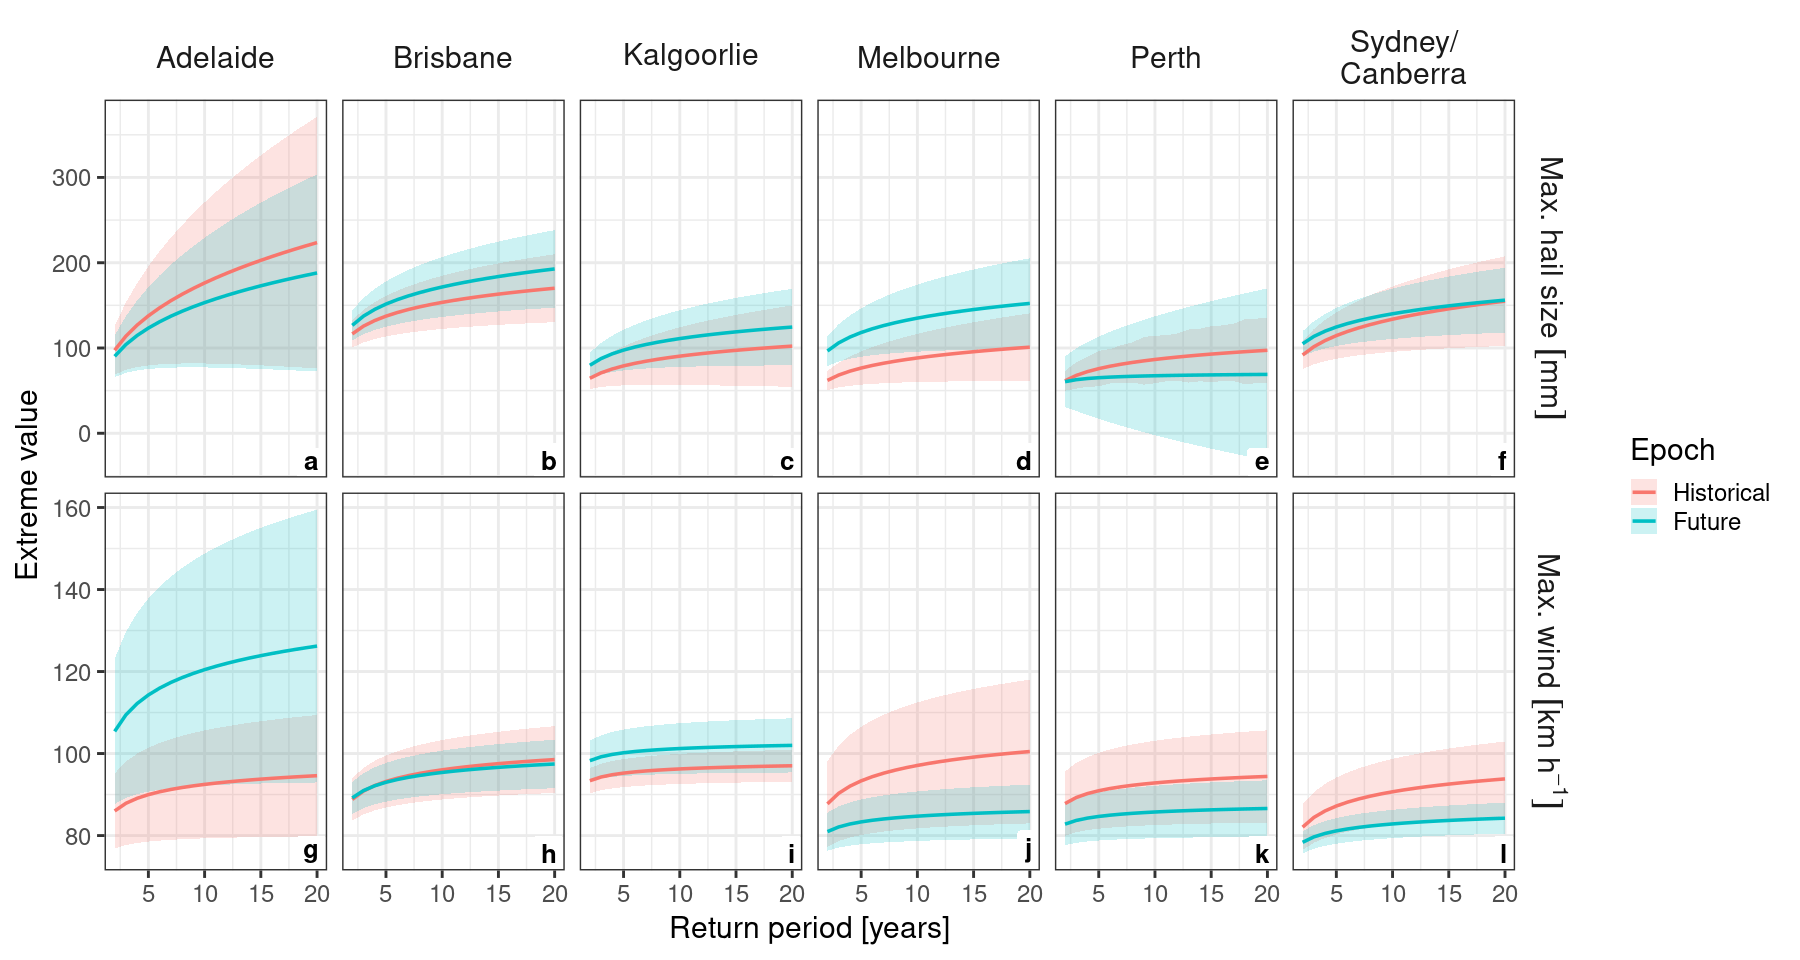

In [20]:
options(repr.plot.width = 15, repr.plot.height = 8)
plot_return_levels(
    gev_fits = gev_fits,
    file = "paper/main/figures/return_periods.pdf"
)

## Threshold exceedence probabilities

Look at probabilities of given levels occurring in a given hail day.

In [21]:
source("modules/gev_functions.R")

ret_periods <- rbind(
    periods_for_thresholds(var = "hailcast_diam_max", thresh = c(50, 100)),
    periods_for_thresholds(var = "wind_10m", thresh = c(80, 100))
)

write_feather(ret_periods, "results/return_periods.feather")
ret_periods %>% pivot_wider(names_from = "epoch", values_from = "period")

threshold,variable,domain,historical,ssp245
<dbl>,<chr>,<chr>,<dbl>,<dbl>
50,hailcast_diam_max,Kalgoorlie,2,2
50,hailcast_diam_max,Adelaide,2,2
50,hailcast_diam_max,Brisbane,2,2
50,hailcast_diam_max,Melbourne,2,2
50,hailcast_diam_max,Perth,2,2
50,hailcast_diam_max,Sydney/Canberra,2,2
100,hailcast_diam_max,Kalgoorlie,18,6
100,hailcast_diam_max,Adelaide,3,3
100,hailcast_diam_max,Brisbane,2,2


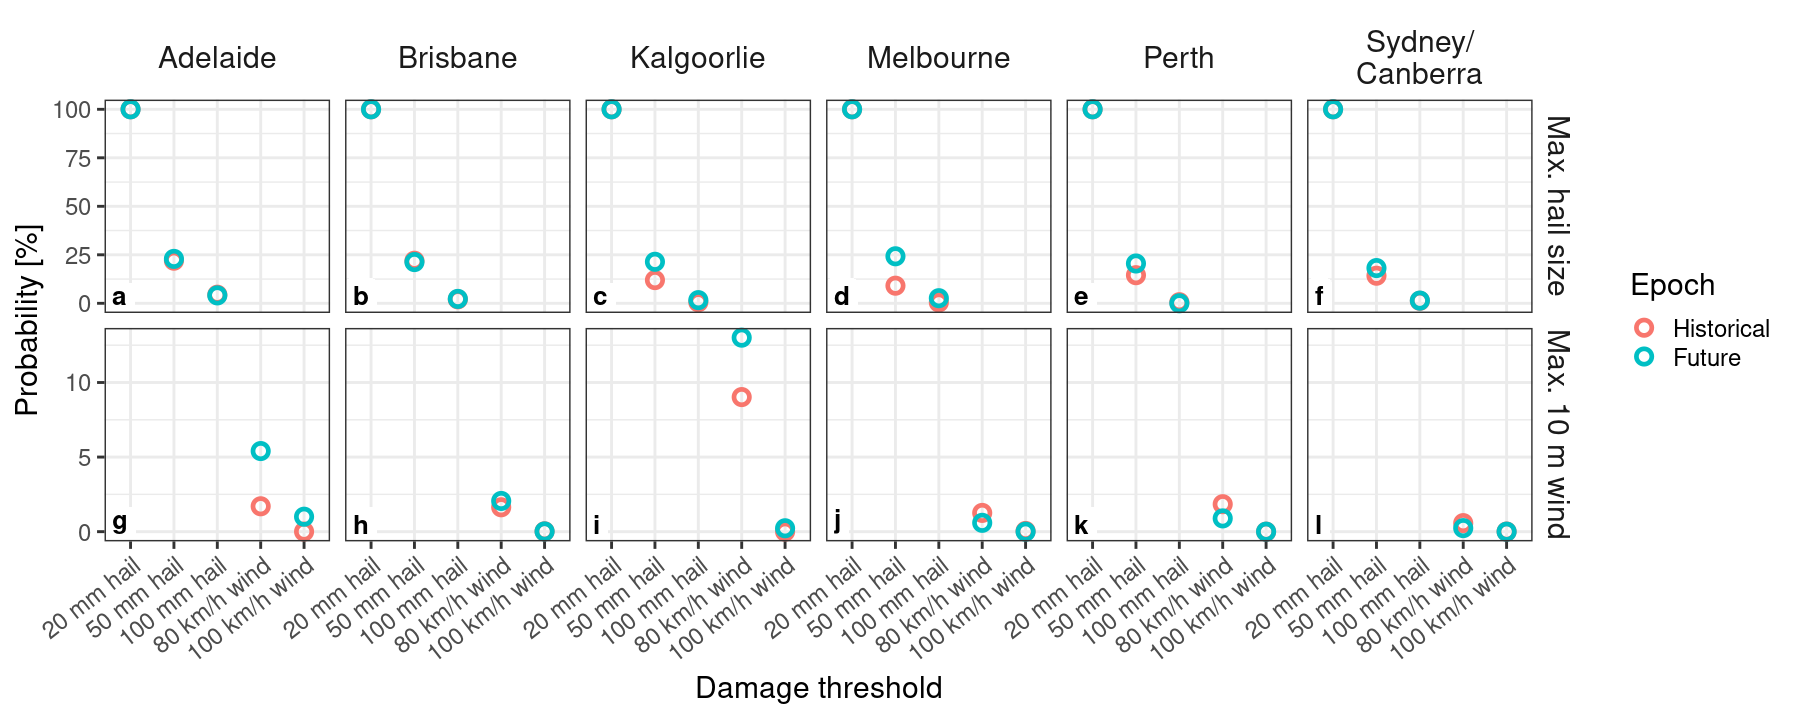

In [22]:
options(repr.plot.width = 15, repr.plot.height = 6)
plot_probs(gev_fits = gev_fits, file = "paper/main/figures/threshold_probs.pdf")


In [23]:
# Write outputs for display in paper.
write_feather(gev_fits$hail_probs, "results/hail_probs.feather")
write_feather(gev_fits$wind_probs, "results/wind_probs.feather")


Show tables of probabilities for given levels.

In [24]:
probabilities_table(gev_fits = gev_fits, out_file = "paper/supporting info/tables/probabilities_table.tex")


## Changes in ingredients

In [25]:
ing_changes = ingredients_changes(ings = means)
max_changes = ingredients_changes(ings = maxes)

Include hail frequency and max hail size changes in the ingredients changes table.

In [26]:
ing_changes <- rbind(
    day_changes$t_test_disp %>%
        select(!starts_with("mean")) %>%
        select(!starts_with("sd")) %>%
        mutate(variable = "Hail days"),
    max_changes %>%
        filter(variable == "Hail size") %>%
        mutate(variable = "Max hail"),
    ing_changes %>%
        filter(variable == "Hail size") %>%
        mutate(variable = "Mean hail"),
    max_changes %>%
        filter(variable == "Wind") %>%
        mutate(variable = "Max wind"),
    ing_changes %>%
        filter(variable == "Wind") %>%
        mutate(variable = "Mean wind"),
    ing_changes %>%
        filter(variable != "Hail size") %>%
        filter(variable != "Wind")
)


Split latex table into two.

In [27]:
ing_table_1 = ing_changes %>% filter(domain %in% c("Adelaide", "Brisbane", "Kalgoorlie"))
ing_table_2 <- ing_changes %>% filter(!(domain %in% c("Adelaide", "Brisbane", "Kalgoorlie")))

tab <- tabular(Factor(variable) ~ Heading() * identity * Heading() * Factor(domain) * Heading() *
                   (rel_change + sig + change_range), data = ing_table_1)
print(toLatex(tab, file = "paper/main/tables/ingredients_1.tex"))

tab <- tabular(Factor(variable) ~ Heading() * identity * Heading() * Factor(domain) * Heading() *
                   (rel_change + sig + change_range), data = ing_table_2)
print(toLatex(tab, file = "paper/main/tables/ingredients_2.tex"))

tab <- tabular(Factor(variable) ~ Heading() * identity * Heading() * Factor(domain) * Heading() *
                   (Format(digits = 1) * historic), data = ing_changes)
print(toLatex(tab, file = "paper/supporting info/tables/historic_means.tex"))

write_feather(ing_changes, "results/ingredient_changes.feather")

Plot correlations between variables at different cities.

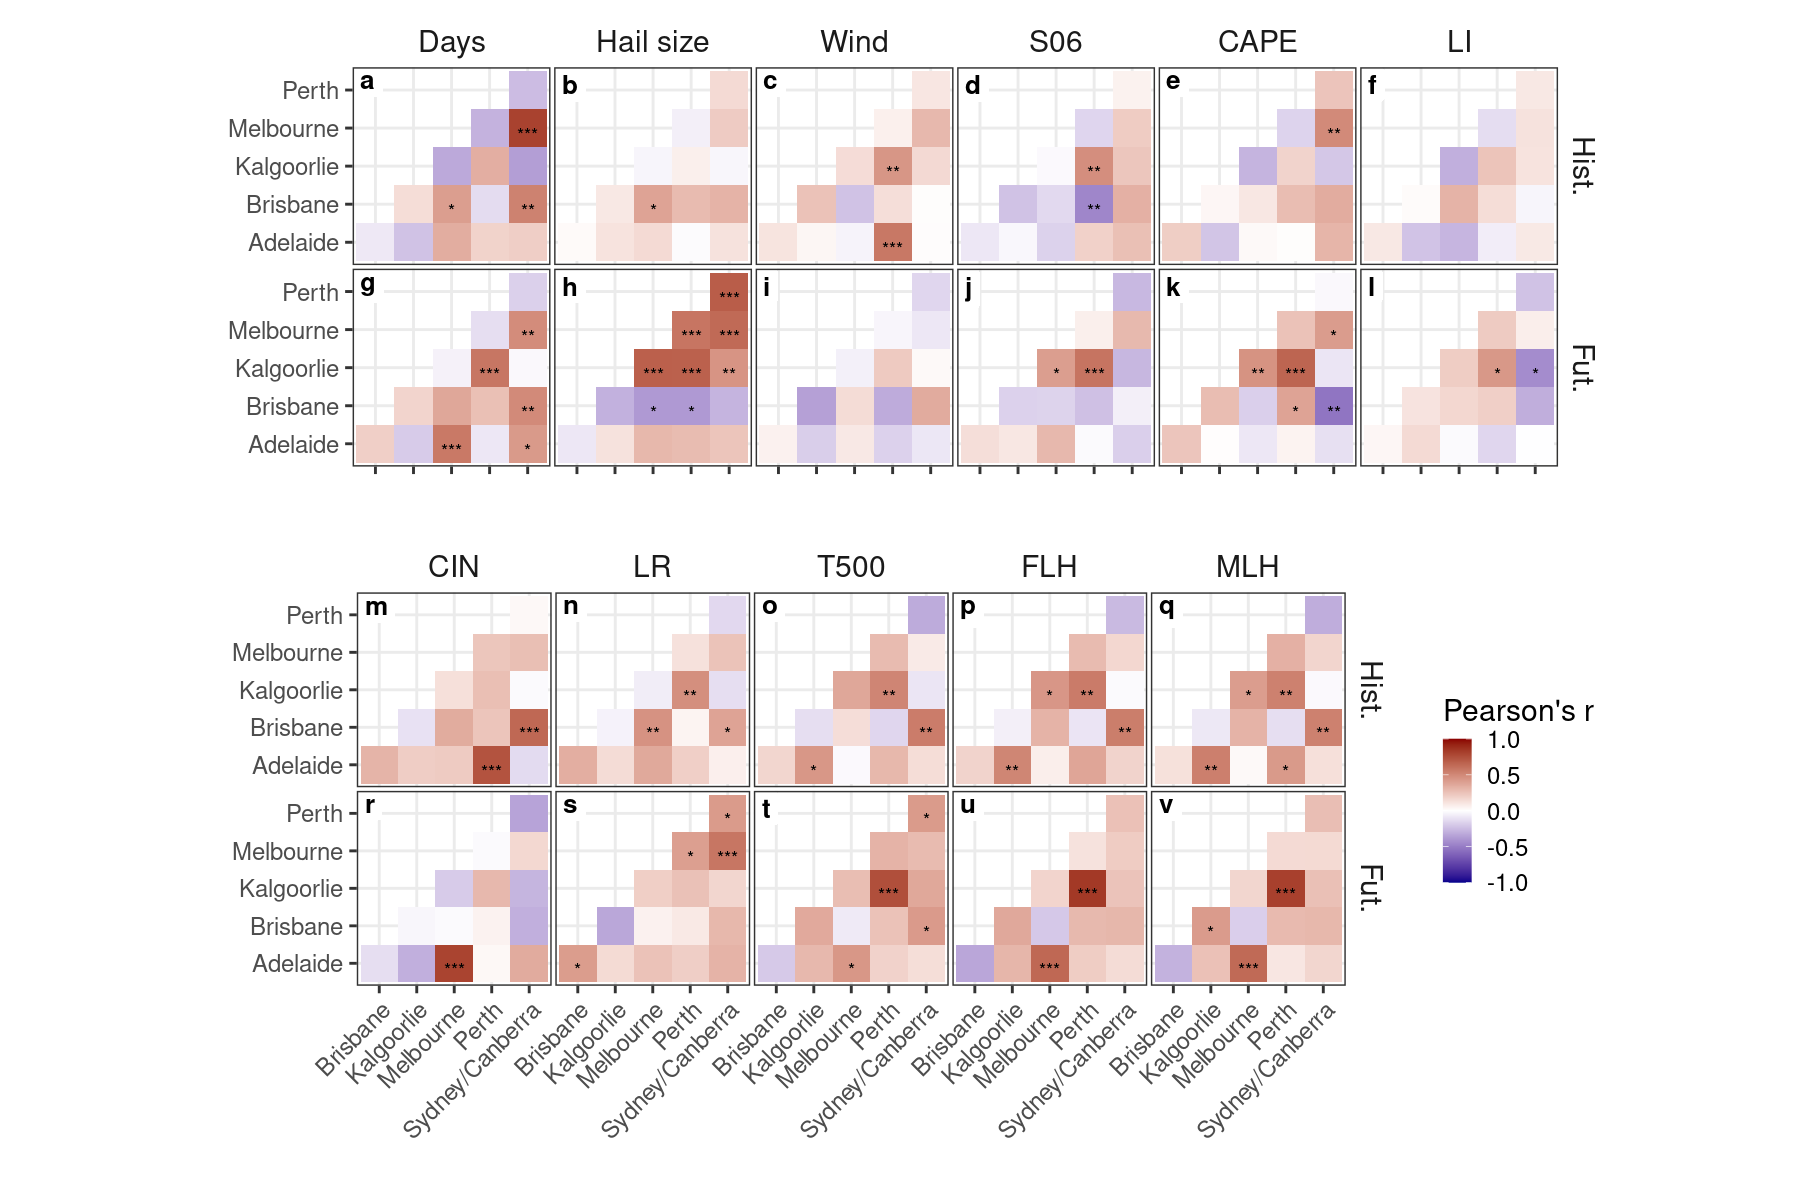

In [28]:
options(repr.plot.width = 15, repr.plot.height = 10)
domain_correlation_plot(means, plot_file = "paper/main/figures/correlations.pdf")